In [6]:
import pandas as pd
import numpy as np

X_resampled = np.load("X_resampled.npy")
y_resampled = np.load("y_resampled.npy")
groups_resampled = np.load("groups_resampled.npy")
df_features = pd.read_csv("Features_130.csv", index_col=0)

0it [00:00, ?it/s]


=== Fold 1 ===
Number of features: 1, Accuracy: 57.13%
Number of features: 2, Accuracy: 54.28%
Number of features: 3, Accuracy: 57.10%
Number of features: 4, Accuracy: 59.60%
Number of features: 5, Accuracy: 60.58%
Number of features: 6, Accuracy: 61.29%
Number of features: 7, Accuracy: 62.05%
Number of features: 8, Accuracy: 63.74%
Number of features: 9, Accuracy: 63.91%
Number of features: 10, Accuracy: 65.15%
Number of features: 11, Accuracy: 64.05%
Number of features: 12, Accuracy: 65.40%
Number of features: 13, Accuracy: 65.14%
Number of features: 14, Accuracy: 65.80%
Number of features: 15, Accuracy: 66.33%
Number of features: 16, Accuracy: 64.86%
Number of features: 17, Accuracy: 65.86%
Number of features: 18, Accuracy: 66.58%
Number of features: 19, Accuracy: 66.63%
Number of features: 20, Accuracy: 66.25%
Number of features: 21, Accuracy: 66.93%
Number of features: 22, Accuracy: 66.99%
Number of features: 23, Accuracy: 66.81%
Number of features: 24, Accuracy: 67.45%
Number of

1it [5:02:46, 18166.85s/it]

Number of features: 130, Accuracy: 69.86%
Processing time for fold 1: 18166.28 seconds

=== Fold 2 ===
Number of features: 1, Accuracy: 53.60%
Number of features: 2, Accuracy: 60.58%
Number of features: 3, Accuracy: 60.46%
Number of features: 4, Accuracy: 60.21%
Number of features: 5, Accuracy: 60.05%
Number of features: 6, Accuracy: 61.69%
Number of features: 7, Accuracy: 63.25%
Number of features: 8, Accuracy: 63.31%
Number of features: 9, Accuracy: 63.43%
Number of features: 10, Accuracy: 64.74%
Number of features: 11, Accuracy: 64.37%
Number of features: 12, Accuracy: 63.96%
Number of features: 13, Accuracy: 65.32%
Number of features: 14, Accuracy: 65.21%
Number of features: 15, Accuracy: 64.53%
Number of features: 16, Accuracy: 65.97%
Number of features: 17, Accuracy: 64.65%
Number of features: 18, Accuracy: 65.13%
Number of features: 19, Accuracy: 64.87%
Number of features: 20, Accuracy: 65.23%
Number of features: 21, Accuracy: 65.22%
Number of features: 22, Accuracy: 65.88%
Numb

2it [10:04:26, 18133.43s/it]

Number of features: 130, Accuracy: 69.32%
Processing time for fold 2: 18100.01 seconds

=== Overall Results ===
Mean Accuracies for each number of features: [0.55364806 0.57429284 0.58783394 0.59901332 0.60311359 0.61493248
 0.62646939 0.63529236 0.63669843 0.64946892 0.64210354 0.64676282
 0.65228499 0.65503716 0.65429906 0.65414669 0.65255849 0.6585202
 0.65750582 0.65739749 0.66071272 0.66437269 0.66476895 0.66898566
 0.66780372 0.66538972 0.6658928  0.67112844 0.67168821 0.66605011
 0.6707299  0.67365482 0.67218635 0.67551069 0.6743314  0.67607628
 0.67196525 0.67578418 0.67989749 0.67466957 0.68264877 0.67832714
 0.6819799  0.67910548 0.67832474 0.68203381 0.68208418 0.68528905
 0.68051042 0.68299415 0.68023768 0.67950288 0.68641999 0.68478965
 0.68259802 0.68068393 0.68377388 0.67775585 0.68850354 0.68647327
 0.6792757  0.68378451 0.68732729 0.68389842 0.67780824 0.68119865
 0.68378261 0.68400473 0.68495924 0.68608511 0.68929504 0.68119384
 0.68491203 0.68164566 0.68597602 0.6886

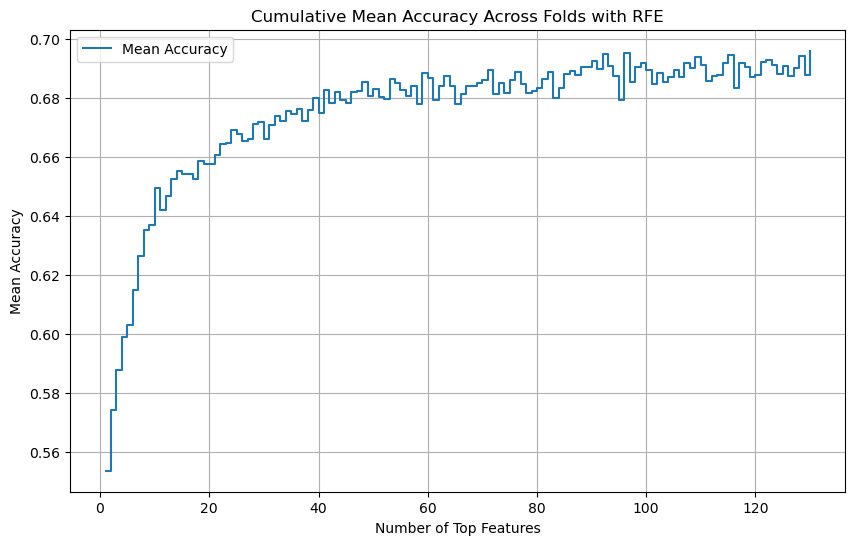

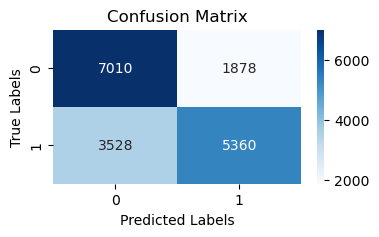

In [7]:
import numpy as np
from collections import Counter
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from scipy.stats import randint, uniform, loguniform


# Cross-validation setup
sgkf = StratifiedGroupKFold(n_splits=2, shuffle=True, random_state=206)  # take n_splits=5 for optimal value

# Initialize variables
fold_accuracies = []
all_test = []
all_pred = []
feature_score_sums = {}
feature_counts = {}

# Splitting according to CV strategy
for fold_idx, (train_idx, test_idx) in tqdm(enumerate(sgkf.split(X_resampled, y_resampled, groups_resampled))):
    print(f"\n=== Fold {fold_idx + 1} ===")
    start_time = time.time()

    # Split into train and test data
    X_train, y_train = X_resampled[train_idx], y_resampled[train_idx]
    X_test, y_test = X_resampled[test_idx], y_resampled[test_idx]

    # List to store accuracy for each number of features
    accuracies = []
    
    max_features = min(130, X_train.shape[1])

    # Compute full RFE ranking
    rfecv = RFE(estimator=CatBoostClassifier(iterations=50, learning_rate=0.1, depth=6, verbose=0), n_features_to_select=1)
    rfecv.fit(X_train, y_train)
    rfe_ranks = rfecv.ranking_
    feature_names = df_features.columns
    rfe_scores = {feature_names[i]: rfe_ranks[i] for i in range(len(feature_names))}
        
    for k in range(1, max_features + 1):
        # Define the pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selector', RFE(estimator=CatBoostClassifier(iterations=50, learning_rate=0.1, depth=6, verbose=0), n_features_to_select=k)),
            ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
        ])

        # Define hyperparameter distributions
        param_distributions = {
            'classifier__n_estimators': randint(100, 501),
            'classifier__max_depth': randint(3, 11),
            'classifier__learning_rate': loguniform(1e-3, 1),
            'classifier__subsample': uniform(0.6, 0.4),
            'classifier__colsample_bytree': uniform(0.6, 0.4),
            'classifier__gamma': uniform(0, 1),
            'classifier__reg_lambda': loguniform(0.1, 10),
            'classifier__reg_alpha': loguniform(0.1, 10),
        }

        # Set up and run RandomizedSearchCV
        random_search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_distributions,
            n_iter=1,  # Adjust n_iter as needed, e.g., 10 for better tuning
            cv=3,
            scoring='accuracy',
            n_jobs=-1,
            random_state=42
        )
        random_search.fit(X_train, y_train)

        # Get the best pipeline
        best_pipeline = random_search.best_estimator_

        # Get selected feature indices
        feature_selector = best_pipeline.named_steps['feature_selector']

        # Get the selected feature indices
        selected_features = feature_selector.get_support(indices=True)

        # Get feature names
        selected_feature_names = [feature_names[idx] for idx in selected_features]

        # Get RFE scores for selected features
        selected_rfe_scores = [rfe_scores[name] for name in selected_feature_names]

        # Update cumulative scores and counts
        for idx, score in zip(selected_features, selected_rfe_scores):
            feature_score_sums[idx] = feature_score_sums.get(idx, 0) + score
            feature_counts[idx] = feature_counts.get(idx, 0) + 1

        # Predict and evaluate
        y_pred = best_pipeline.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)

        print(f"Number of features: {k}, Accuracy: {acc * 100:.2f}%")

    # Store predictions for overall evaluation
    all_test.extend(y_test)
    all_pred.extend(y_pred)
    fold_accuracies.append(accuracies)

    end_time = time.time()
    print(f"Processing time for fold {fold_idx + 1}: {end_time - start_time:.2f} seconds")

# Compute average feature scores
average_feature_scores = []
for feature_idx in feature_score_sums:
    avg_score = feature_score_sums[feature_idx] / feature_counts[feature_idx]
    average_feature_scores.append((feature_idx, avg_score))

# Summary
print("\n=== Overall Results ===")
mean_accuracies = np.mean(fold_accuracies, axis=0)
print("Mean Accuracies for each number of features:", mean_accuracies)

# Plot overall cumulative accuracy across folds
plt.figure(figsize=(10, 6))
plt.step(range(1, max_features + 1), mean_accuracies, where='post', label='Mean Accuracy')
plt.xlabel('Number of Top Features')
plt.ylabel('Mean Accuracy')
plt.title('Cumulative Mean Accuracy Across Folds with RFE')
plt.legend()
plt.grid(True)
plt.show()

# Visualize overall confusion matrix
cm = confusion_matrix(all_test, all_pred)
plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [8]:
df = pd.DataFrame(average_feature_scores)
average_feature_scores_indices = []
average_feature_scores_list=[]
for i, j in average_feature_scores:
    average_feature_scores_indices.append(i)
average_feature_scores_indices

[64,
 90,
 23,
 40,
 91,
 80,
 97,
 32,
 67,
 63,
 6,
 19,
 112,
 48,
 8,
 39,
 102,
 25,
 54,
 21,
 43,
 105,
 14,
 15,
 101,
 41,
 12,
 116,
 38,
 44,
 114,
 45,
 22,
 99,
 88,
 4,
 10,
 33,
 107,
 24,
 108,
 73,
 52,
 79,
 3,
 118,
 28,
 104,
 5,
 55,
 34,
 31,
 42,
 17,
 94,
 0,
 76,
 36,
 74,
 27,
 37,
 13,
 9,
 51,
 35,
 126,
 109,
 98,
 113,
 16,
 68,
 117,
 7,
 120,
 103,
 71,
 125,
 65,
 50,
 49,
 124,
 121,
 106,
 122,
 87,
 1,
 123,
 82,
 115,
 69,
 30,
 96,
 2,
 11,
 77,
 53,
 92,
 111,
 81,
 72,
 20,
 83,
 46,
 110,
 95,
 29,
 75,
 70,
 56,
 57,
 58,
 86,
 59,
 89,
 119,
 26,
 84,
 60,
 93,
 78,
 61,
 62,
 85,
 127,
 128,
 18,
 47,
 129,
 100,
 66]

In [9]:
for i in average_feature_scores_indices:
    average_feature_scores_list.append(df_features.columns[i])
average_feature_scores_list


['LZC',
 'min',
 'avg_diastolic_area',
 'ab_duration',
 'max',
 'LZC_PPG',
 'zero_cross',
 'd_amp',
 'MSE_PermEn_τ1',
 'ApEn',
 'iqr_time_diff_dic_ends',
 'max_rise_slope',
 'dwt_cA4_min',
 'MedianNN',
 'avg_time_diff_p1_dia',
 'f/a_ratio',
 'moment-3',
 'avg_area_under_pulse',
 'NN50',
 'min_fall_slope',
 'total_wave_duration',
 'moment-6',
 'avg_reflection_index',
 'avg_reflection_index_p1',
 'median',
 'bc_duration',
 'std_pulse_wave_amplitude',
 'dwt_cD4_min',
 'e/a_ratio',
 'aging_index',
 'dwt_cD4_max',
 'vascular_index',
 'avg_systolic_area',
 'skewness',
 'SHF',
 'iqr_time_diff_onset_dic',
 'pulse_rate',
 'e_amp',
 'diff_2',
 'avg_IPA',
 'diff_1_kstd',
 'MSE_PermEn_τ3',
 'CVSD',
 'MSE_PermEn_τ5',
 'avg_time_diff_onset_dic',
 'dwt_cD3_max',
 'avg_total_area_rate',
 'moment-5',
 'avg_time_diff_dic_ends',
 'PNN50',
 'f_amp',
 'c_amp',
 'bd_duration',
 'ratio_p1_p2',
 'mean_energy',
 'avg_time_diff_sys_dia',
 'MSE_PermEn_τ4',
 'c/a_ratio',
 'MSE_SampEn_τ4',
 'avg_fall_area_rate',
 

In [10]:
df = pd.DataFrame(average_feature_scores)
df

,0,1
0,64,6.671533
1,90,2.996109
2,23,22.827907
3,40,27.666667
4,91,5.000000
...,...,...
125,18,92.909091
126,47,91.857143
127,129,128.400000
128,100,9.936000


In [11]:
df.rename(columns = {0:'features',1:'mi_scores'}, inplace=True)
df

,features,mi_scores
0,64,6.671533
1,90,2.996109
2,23,22.827907
3,40,27.666667
4,91,5.000000
...,...,...
125,18,92.909091
126,47,91.857143
127,129,128.400000
128,100,9.936000


In [12]:
df.to_csv('feature_with_rfe_scores_xgboost.csv')

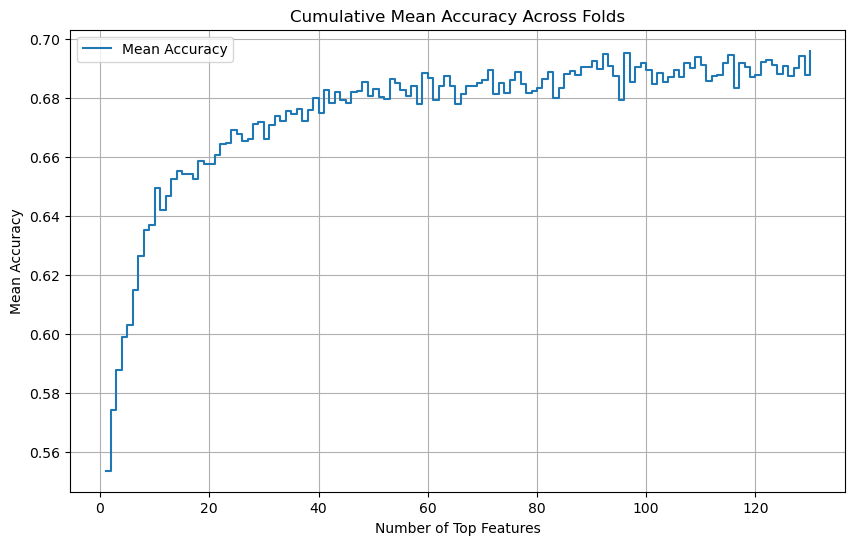

In [13]:
plt.figure(figsize=(10, 6))
plt.step(range(1, max_features + 1), mean_accuracies, where='post', label='Mean Accuracy')
plt.xlabel('Number of Top Features')
plt.ylabel('Mean Accuracy')
plt.title('Cumulative Mean Accuracy Across Folds')
plt.legend()
plt.grid(True)
plt.savefig("step_plot_rfe_scores_xgboost.pdf",bbox_inches='tight')

plt.show()